In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
import sympy as sy
import simtk.unit as unit
from simtk import openmm as mm
from simtk.openmm import app
import skopt as skopt
from tqdm import tqdm

# 2D Lennard-Jones fluid

In [2]:
mass = 39.948 * unit.amu
sigma = 3.404 * unit.angstroms
epsilon = 0.238 * unit.kilocalories_per_mole
charge = 0.0 * unit.elementary_charge

n_particles = 1
reduced_density = 0.15
l_box = 400.0 * unit.angstroms

In [3]:
temperature = 300.00 * unit.kelvin
integration_timestep = 0.002 * unit.picoseconds
collisions_rate = 1.0 / unit.picoseconds

equilibration_time = 0.5 * unit.nanoseconds
production_time = 0.10 * unit.nanoseconds
saving_time = 0.1 * unit.picoseconds

equilibration_n_steps = round(equilibration_time/integration_timestep)

In [4]:
radius = 2.0**(-5/6) * sigma
print(radius)

1.9104304062225528 A


In [5]:
if l_box is None:
    area_particles = n_particles*np.pi*radius**2
    area = area_particles/reduced_density
    l_box = area**(1/2)
    print('Side of the box: {}'.format(l_box))
else:
    area_particles = n_particles*np.pi*radius**2
    area = l_box**2
    reduced_density = area_particles/area
    print('Reduced density: {}'.format(reduced_density))

Reduced density: 7.166256247913711e-05


In [6]:
space = skopt.Space([[0.0, l_box._value], [0.0, l_box._value]])
#generator = skopt.sampler.Grid(use_full_layout=False)
generator = skopt.sampler.Lhs(criterion="maximin", iterations=10000)
positions_2d = generator.generate(space.dimensions, n_particles)
positions_2d = np.array(positions_2d)*unit.angstroms

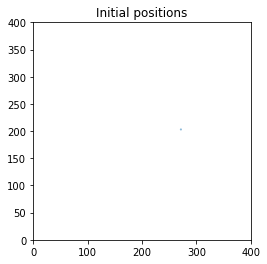

In [7]:
ax = plt.subplot(aspect='equal')

patches=[]
for ii in range(n_particles):
    patches.append(Circle(positions_2d[ii,:]._value, radius._value))

p = PatchCollection(patches, alpha=0.5)
ax.add_collection(p)

ax.set_title("Initial positions")
ax.set_xlim([0.0, l_box._value])
ax.set_ylim([0.0, l_box._value])
plt.show()

In [8]:
system = mm.System()

for _ in range(n_particles):
    system.addParticle(mass)

In [9]:
v1 = np.zeros(3) * unit.angstroms
v2 = np.zeros(3) * unit.angstroms
v3 = np.zeros(3) * unit.angstroms

v1[0] = l_box
v2[1] = l_box
v3[2] = l_box

system.setDefaultPeriodicBoxVectors(v1, v2, v3)

In [10]:
non_bonded_force = mm.NonbondedForce()
non_bonded_force.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)
non_bonded_force.setCutoffDistance(3.0*sigma)
non_bonded_force.setUseSwitchingFunction(True)
non_bonded_force.setSwitchingDistance(2.0*sigma)
non_bonded_force.setUseDispersionCorrection(True)

for _ in range(n_particles):
    non_bonded_force.addParticle(charge, sigma, epsilon)

_ = system.addForce(non_bonded_force)

In [11]:
armonic_force = mm.CustomExternalForce('A*(z^2)')
k=1.0*unit.kilocalories_per_mole/unit.nanometers**2
armonic_force.addGlobalParameter('A', 0.5*k)
for ii in range(n_particles):
    armonic_force.addParticle(ii, [])
_ = system.addForce(armonic_force)

In [12]:
integrator = mm.LangevinIntegrator(temperature, collisions_rate, integration_timestep)
platform = mm.Platform.getPlatformByName('CUDA')
context = mm.Context(system, integrator, platform)

In [13]:
initial_positions=np.zeros([n_particles,3])*unit.angstroms
initial_positions[:,0:2]=positions_2d[:,:]

initial_velocities=np.zeros([n_particles,3])*unit.angstroms/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)
#context.setVelocitiesToTemperature(temperature)

In [14]:
state=context.getState(getEnergy=True)
print("Before minimization: {}".format(state.getPotentialEnergy()))
mm.LocalEnergyMinimizer_minimize(context)
state=context.getState(getEnergy=True, getPositions=True)
print("After minimization: {}".format(state.getPotentialEnergy()))

Before minimization: -3.401325030358018e-07 kJ/mol
After minimization: -3.401325030358018e-07 kJ/mol


In [15]:
positions_after_minimization = state.getPositions(asNumpy=True)

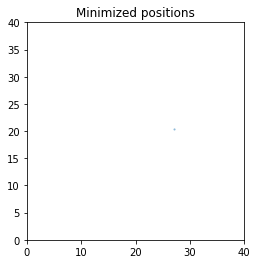

In [16]:
ax = plt.subplot(aspect='equal')

patches=[]
for ii in range(n_particles):
    patches.append(Circle(positions_after_minimization[ii,0:2]._value, 0.1*radius._value))

p = PatchCollection(patches, alpha=0.5)
ax.add_collection(p)

ax.set_title("Minimized positions")
ax.set_xlim([0.0, 0.1*l_box._value])
ax.set_ylim([0.0, 0.1*l_box._value])
plt.show()

In [17]:
#equilibration_n_steps = round(equilibration_time/integration_timestep)
#integrator.step(equilibration_n_steps)
#context.setTime(0.0*unit.picoseconds)

In [18]:
production_n_steps = int(production_time/integration_timestep)
saving_n_steps = int(saving_time/integration_timestep)
n_saving_periods = int(production_n_steps/saving_n_steps)

time = np.zeros([n_saving_periods+1]) * unit.nanoseconds
trajectory = np.zeros([n_saving_periods+1, n_particles, 3]) * unit.angstroms
potential_energy = np.zeros([n_saving_periods+1]) * unit.kilocalories_per_mole
kinetic_energy = np.zeros([n_saving_periods+1]) * unit.kilocalories_per_mole

state = context.getState(getPositions=True, getEnergy=True, enforcePeriodicBox = False)
time[0] = state.getTime()
trajectory[0,:,:] = state.getPositions(asNumpy=True)
potential_energy[0] = state.getPotentialEnergy()
kinetic_energy[0] = state.getKineticEnergy()
for ii in tqdm(range(1,n_saving_periods+1)):
    integrator.step(saving_n_steps)
    #remove enforcePeriodicBox to get unwrapped trajectories
    state = context.getState(getPositions=True, getEnergy=True, enforcePeriodicBox = False)
    time[ii] = state.getTime()
    trajectory[ii,:,:] = state.getPositions(asNumpy=True)
    potential_energy[ii] = state.getPotentialEnergy()
    kinetic_energy[ii] = state.getKineticEnergy()

100%|██████████| 1000/1000 [00:02<00:00, 343.44it/s]


In [19]:
trajectory_mem = trajectory.size * trajectory.itemsize * unit.bytes
print('Trajectory size: {} MB'.format(trajectory_mem._value/(1024*1024)))

Trajectory size: 0.02291107177734375 MB


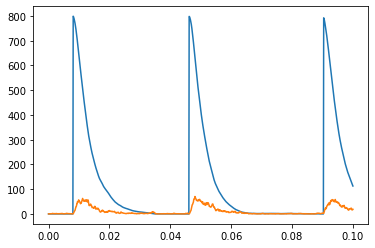

In [20]:
plt.plot(time, potential_energy)
plt.plot(time, kinetic_energy)
plt.show()

In [ ]:
total_energy = kinetic_energy+potential_energy
plt.plot(time, total_energy)
plt.ylim([total_energy.min()._value-0.1, total_energy.max()._value+0.1])
plt.show()

In [ ]:
plt.plot(time[0:1000], trajectory[0:1000,:,2])
#plt.plot(time, trajectory[:,0,1])
#plt.plot(time, trajectory[:,0,2])
#plt.plot(time, trajectory[:,100,0])
#plt.plot(time, trajectory[:,100,1])
#plt.plot(time, trajectory[:,100,2])

In [ ]:
trajectory[50,0,:]

In [ ]:
#fig = plt.figure()
plt.rcParams["animation.html"] = "jshtml"
fig, ax = plt.subplots()
#ax = plt.subplot(aspect='equal')
ax.set_aspect('equal', 'box')
ax.set_title("2D LJ Fluid")
ax.set_xlim([0.0, l_box._value])
ax.set_ylim([0.0, l_box._value])


frame=0
patches=[]
for ii in range(n_particles):
    patches.append(Circle(trajectory[frame,ii,0:2]._value, radius._value))

p = PatchCollection(patches, alpha=0.5)
ax.add_collection(p)

def animate(frame):

    global trajectory, radius, p

    patches=[]
    for ii in range(n_particles): 
        patches.append(Circle(trajectory[frame,ii,0:2]._value, radius._value))
        
    p.set_paths(patches)
    
ani = animation.FuncAnimation(fig, animate, frames=trajectory.shape[0], interval=100, blit=False)
plt.close()
ani

ToDo:

n_particles=10, Temperature=0, 